# Instituto Tecnológico y de Estudios Superiores de Monterrey
## Maestría en Inteligencia Artificial Aplicada
### Proyecto Integrador (Gpo 10) - TC5035.10

### **Proyecto: Diseño Acelerado de Fármacos**

### Avance 4: Modelos alternativos

#### **Docentes:**
- Dra. Grettel Barceló Alonso - Profesor Titular
- Dr. Luis Eduardo Falcón Morales - Profesor Titular
- Dr. Horacio Martinez Alfaro  – Profesor Tutor

#### **Miembros del equipo:**
 - Jose Luis Artigas Arroyo - A01794906
 - José Luis Fabela Portillo - A00748551
 - Alejandro Emmanuel Silva Ortega - A01794545

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import re
from sklearn.svm import SVC
import pickle
import joblib

In [3]:
#Define el path de los archivos necesarios
model_path = '../models/svc_model.pkl'
X_path = '../data/processed/DTCPep_pca_pfeatures.csv'
y_path = '../data/processed/DTCPep_y.csv'

In [4]:

baseline_model = joblib.load(model_path)
baseline_model

SVC(C=10, gamma=0.01, random_state=4)

In [5]:
X = pd.read_csv(X_path)
y = pd.read_csv(y_path)

# Separar datasets en train y test
Como primer paso separamos el dataset en entrenamiento (80%), prueba (16%) y validación (4%)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state =42, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state =4, stratify=y_train)

In [7]:
baseline_model.predict(X_test)

array([0, 0, 1, ..., 0, 0, 0], shape=(5177,))

In [8]:
# MODELS BUILDING AND PERFORMANCE EVALUATION

# Import required libraries for performance metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_validate
# Import required libraries for machine learning classifiers
from sklearn.linear_model import PassiveAggressiveClassifier, RidgeClassifierCV
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from scipy.stats import loguniform

In [9]:
# Define dictionary with performance metrics
scoring = {'accuracy':make_scorer(accuracy_score), 
           'precision':make_scorer(precision_score),
           'recall':make_scorer(recall_score), 
           'f1_score':make_scorer(f1_score)}

In [11]:
# Instantiate the machine learning classifiers
pac_model = PassiveAggressiveClassifier(n_jobs = -1, random_state= 4)
svc_model = LinearSVC(dual=False, random_state=4)
dtr_model = DecisionTreeClassifier(random_state=4)
rfc_model = RandomForestClassifier(n_jobs = -1, random_state= 4)
gnb_model = GaussianNB()
adaboost_model = AdaBoostClassifier(random_state=4)
ridge_model = RidgeClassifierCV()	

In [12]:
# Define the models evaluation function
def models_evaluation(baseline, X, y, folds):
    
    '''
    X : data set features
    y : data set target
    folds : number of cross-validation folds
    
    '''
    
    # Perform cross-validation to each machine learning classifier
    baseline = cross_validate(baseline, X, y, cv=folds, scoring=scoring) 
    pac = cross_validate(pac_model, X, y, cv=folds, scoring=scoring)
    svc = cross_validate(svc_model, X, y, cv=folds, scoring=scoring)
    dtr = cross_validate(dtr_model, X, y, cv=folds, scoring=scoring)
    rfc = cross_validate(rfc_model, X, y, cv=folds, scoring=scoring)
    gnb = cross_validate(gnb_model, X, y, cv=folds, scoring=scoring)
    adaboost = cross_validate(adaboost_model, X, y, cv=folds, scoring=scoring)
    ridge = cross_validate(ridge_model, X, y, cv=folds, scoring=scoring)

    # Create a data frame with the models perfoamnce measures scores
    models_scores_table = pd.DataFrame({'Base Model':[baseline['test_accuracy'].mean(),
                                                               baseline['test_precision'].mean(),
                                                               baseline['test_recall'].mean(),
                                                               baseline['test_f1_score'].mean()],
                                        'PasiveAgresiveClassifier':[pac['test_accuracy'].mean(),
                                                               pac['test_precision'].mean(),
                                                               pac['test_recall'].mean(),
                                                               pac['test_f1_score'].mean()],
                                       
                                      'Support Vector Classifier':[svc['test_accuracy'].mean(),
                                                                   svc['test_precision'].mean(),
                                                                   svc['test_recall'].mean(),
                                                                   svc['test_f1_score'].mean()],
                                       
                                      'Decision Tree':[dtr['test_accuracy'].mean(),
                                                       dtr['test_precision'].mean(),
                                                       dtr['test_recall'].mean(),
                                                       dtr['test_f1_score'].mean()],
                                       
                                      'Random Forest':[rfc['test_accuracy'].mean(),
                                                       rfc['test_precision'].mean(),
                                                       rfc['test_recall'].mean(),
                                                       rfc['test_f1_score'].mean()],
                                       
                                      'Gaussian Naive Bayes':[gnb['test_accuracy'].mean(),
                                                              gnb['test_precision'].mean(),
                                                              gnb['test_recall'].mean(),
                                                              gnb['test_f1_score'].mean()],
                                       
                                       'AdaBoost':[adaboost['test_accuracy'].mean(),
                                                              adaboost['test_precision'].mean(),
                                                              adaboost['test_recall'].mean(),
                                                              adaboost['test_f1_score'].mean()],
                                        
                                        'RidgeCV':[ridge['test_accuracy'].mean(),
                                                              ridge['test_precision'].mean(),
                                                              ridge['test_recall'].mean(),
                                                              ridge['test_f1_score'].mean()]},
                                      
                                      index=['Accuracy', 'Precision', 'Recall', 'F1 Score'])
    
    # Add 'Best Score' column
    models_scores_table['Best Score'] = models_scores_table.idxmax(axis=1)
    
    # Return models performance metrics scores data frame
    return(models_scores_table)

In [13]:
# Run models_evaluation function
models_score = models_evaluation(baseline_model,X_train,y_train,5)
models_score

c:\Users\drjla\OneDrive\Desktop\MNA\proyecto\Advanced_drug_discovery\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\drjla\OneDrive\Desktop\MNA\proyecto\Advanced_drug_discovery\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\drjla\OneDrive\Desktop\MNA\proyecto\Advanced_drug_discovery\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\drjla\OneDrive\Desktop\MNA\proyecto\Advance

,Base Model,PasiveAgresiveClassifier,Support Vector Classifier,Decision Tree,Random Forest,Gaussian Naive Bayes,AdaBoost,RidgeCV,Best Score
Accuracy,0.811033,0.625153,0.709518,0.729606,0.805778,0.682477,0.715391,0.711835,Base Model
Precision,0.751370,0.413889,0.604728,0.582711,0.789030,0.511862,0.590797,0.619789,Random Forest
Recall,0.625393,0.455881,0.303666,0.587339,0.548292,0.484545,0.399802,0.291768,Base Model
F1 Score,0.682235,0.425317,0.403764,0.584955,0.646654,0.497272,0.475419,0.395989,Base Model


# Grid Search tunning 

## Random forest

In [14]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results["rank_test_score"] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print(
                "Mean validation score: {0:.3f} (std: {1:.3f})".format(
                    results["mean_test_score"][candidate],
                    results["std_test_score"][candidate],
                )
            )
            print("Parameters: {0}".format(results["params"][candidate]))
            print("")


In [62]:
# Definir el diccionario de hiperparámetros
rf_params = dict( max_depth = np.linspace(10, 50, num=1).astype(int),
              n_estimators = np.linspace(100, 200, num=5).astype(int),
              criterion = ['entropy', 'log_loss'],
              max_features = ['sqrt', 'log2'],
              class_weight = ['balanced', 'balanced_subsample']
              
)

# Configurar RandomizedSearchCV
n_iter_search = 15
rfc_random_search = RandomizedSearchCV(
    rfc_model, param_distributions=rf_params, n_iter=n_iter_search, n_jobs= -1, verbose=3, scoring = scoring, refit = 'precision'
)

# Ajustar el modelo
rfc_random_search.fit(X_train,y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


c:\Users\drjla\OneDrive\Desktop\MNA\proyecto\Advanced_drug_discovery\.venv\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomizedSearchCV(estimator=RandomForestClassifier(n_jobs=-1, random_state=4),
                   n_iter=15, n_jobs=-1,
                   param_distributions={'class_weight': ['balanced',
                                                         'balanced_subsample'],
                                        'criterion': ['entropy', 'log_loss'],
                                        'max_depth': array([10]),
                                        'max_features': ['sqrt', 'log2'],
                                        'n_estimators': array([100, 125, 150, 175, 200])},
                   refit='precision',
                   scoring={'accuracy': make_scorer(accuracy_score, response_method='predict'),
                            'f1_score': make_scorer(f1_score, response_method='predict'),
                            'precision': make_scorer(precision_score, response_method='predict'),
                            'recall': make_scorer(recall_score, response_method='predict')},
                   verbose=3)

In [63]:
# Mejor estimador encontrado
rfc_random_search.best_estimator_

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=np.int64(10), max_features='log2',
                       n_estimators=np.int64(100), n_jobs=-1, random_state=4)

In [64]:
rfc_random_search.scorer_

{'accuracy': make_scorer(accuracy_score, response_method='predict'),
 'precision': make_scorer(precision_score, response_method='predict'),
 'recall': make_scorer(recall_score, response_method='predict'),
 'f1_score': make_scorer(f1_score, response_method='predict')}

In [65]:
# Predice valores de y
y_predict_rfc_train = rfc_random_search.predict(X_train)
y_predict_rfc_val = rfc_random_search.predict(X_val)
y_predict_rfc_test = rfc_random_search.predict(X_test)

# Calcula la precisión
accuracy_rfc_train = accuracy_score(y_train,y_predict_rfc_train)
accuracy_rfc_val = accuracy_score(y_val,y_predict_rfc_val)
accuracy_rfc_test = accuracy_score(y_test,y_predict_rfc_test)

print(f'Accuracy train {accuracy_rfc_train}')
print(f'Accuracy val {accuracy_rfc_val}')
print(f'Accuracy test {accuracy_rfc_test}')


Accuracy train 0.8601668726823238
Accuracy val 0.8532818532818532
Accuracy test 0.8618891249758548


In [66]:
# Scores
print(classification_report(y_train, y_predict_rfc_train, target_names=['positive','negative']))
print(classification_report(y_val, y_predict_rfc_val, target_names=['positive','negative']))
print(classification_report(y_test, y_predict_rfc_test, target_names=['positive','negative']))

              precision    recall  f1-score   support

    positive       0.93      0.85      0.89      4371
    negative       0.74      0.87      0.80      2101

    accuracy                           0.86      6472
   macro avg       0.84      0.86      0.85      6472
weighted avg       0.87      0.86      0.86      6472

              precision    recall  f1-score   support

    positive       0.93      0.85      0.89       875
    negative       0.73      0.87      0.79       420

    accuracy                           0.85      1295
   macro avg       0.83      0.86      0.84      1295
weighted avg       0.87      0.85      0.86      1295

              precision    recall  f1-score   support

    positive       0.93      0.86      0.89      3496
    negative       0.74      0.87      0.80      1681

    accuracy                           0.86      5177
   macro avg       0.84      0.87      0.85      5177
weighted avg       0.87      0.86      0.86      5177



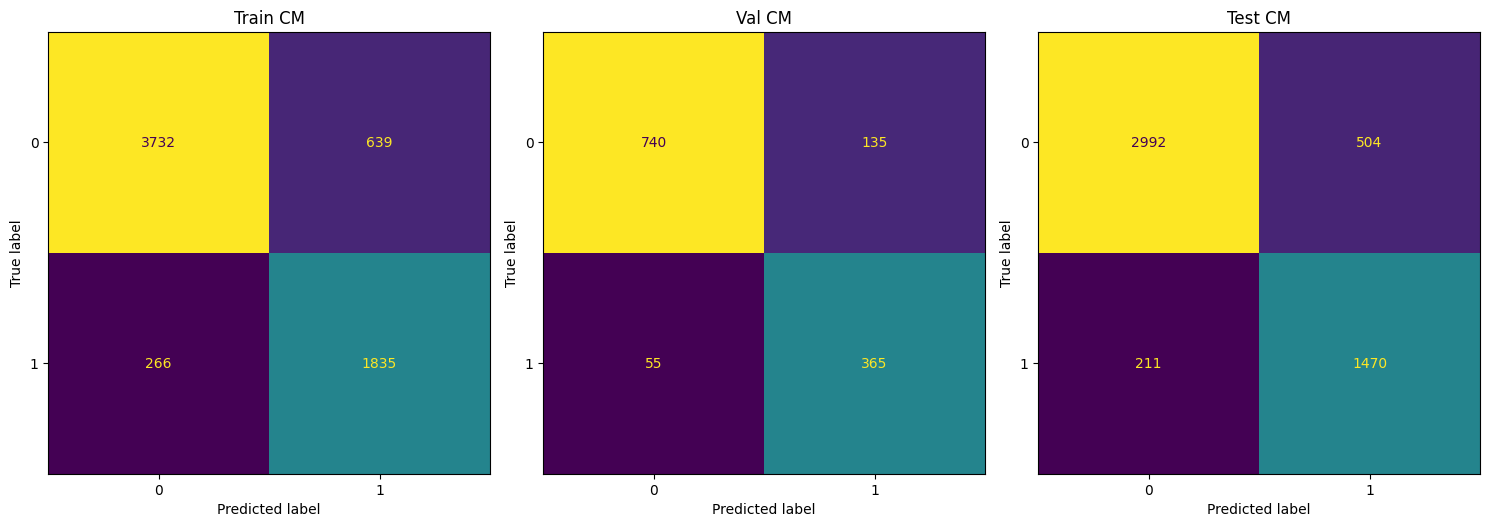

In [67]:
# Crear figuras y ejes
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 fila, 3 columnas

# Matriz de confusión para el conjunto de entrenamiento
cm_rf_train = confusion_matrix(y_train, y_predict_rfc_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf_train)
disp.plot(ax=axes[0], colorbar=False)
axes[0].set_title('Train CM')

# Matriz de confusión para el conjunto de validación
cm_rf_val = confusion_matrix(y_val, y_predict_rfc_val)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf_val)
disp.plot(ax=axes[1], colorbar=False)
axes[1].set_title('Val CM')

# Matriz de confusión para el conjunto de prueba
cm_rf_test = confusion_matrix(y_test, y_predict_rfc_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf_test)
disp.plot(ax=axes[2], colorbar=False)
axes[2].set_title('Test CM')

# Ajustar el espacio entre los gráficos
plt.tight_layout()
plt.show()


## Decision Tree

In [69]:
# Definir el diccionario de hiperparámetros
dtr_params = dict(
    max_depth=np.linspace(10, 50, num=5).astype(int),   # Profundidad máxima del árbol
    criterion=['gini', 'entropy'],                     # Criterio para medir la calidad de una división
    splitter=['best', 'random'],                       # Estrategia utilizada para elegir la división en cada nodo
    min_samples_split=[2, 5, 10],                      # Número mínimo de muestras requeridas para dividir un nodo interno
    min_samples_leaf=[1, 2, 4])          

# Configurar RandomizedSearchCV
n_iter_search = 15
dtr_random_search = RandomizedSearchCV(
    dtr_model, 
    param_distributions=dtr_params, 
    n_iter=n_iter_search, 
    n_jobs= -1, 
    verbose=3, 
    scoring = scoring, 
    refit = 'precision')

# Ajustar el modelo
dtr_random_search.fit(X_train,y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


RandomizedSearchCV(estimator=DecisionTreeClassifier(random_state=4), n_iter=15,
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': array([10, 20, 30, 40, 50]),
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'splitter': ['best', 'random']},
                   refit='precision',
                   scoring={'accuracy': make_scorer(accuracy_score, response_method='predict'),
                            'f1_score': make_scorer(f1_score, response_method='predict'),
                            'precision': make_scorer(precision_score, response_method='predict'),
                            'recall': make_scorer(recall_score, response_method='predict')},
                   verbose=3)

In [70]:
# Mejor estimador encontrado
dtr_random_search.best_estimator_

DecisionTreeClassifier(max_depth=np.int64(30), min_samples_leaf=4,
                       random_state=4, splitter='random')

In [71]:
dtr_random_search.scorer_

{'accuracy': make_scorer(accuracy_score, response_method='predict'),
 'precision': make_scorer(precision_score, response_method='predict'),
 'recall': make_scorer(recall_score, response_method='predict'),
 'f1_score': make_scorer(f1_score, response_method='predict')}

In [72]:
# Predice valores de y
y_predict_dtr_train = dtr_random_search.predict(X_train)
y_predict_dtr_val = dtr_random_search.predict(X_val)
y_predict_dtr_test = dtr_random_search.predict(X_test)

# Calcula la precisión
accuracy_dtr_train = accuracy_score(y_train,y_predict_dtr_train)
accuracy_dtr_val = accuracy_score(y_val,y_predict_dtr_val)
accuracy_dtr_test = accuracy_score(y_test,y_predict_dtr_test)

print(f'Accuracy train {accuracy_dtr_train}')
print(f'Accuracy val {accuracy_dtr_val}')
print(f'Accuracy test {accuracy_dtr_test}')

Accuracy train 0.8819530284301607
Accuracy val 0.8872586872586873
Accuracy test 0.8806258450840255


In [73]:
# Scores
print(classification_report(y_train, y_predict_dtr_train, target_names=['positive','negative']))
print(classification_report(y_val, y_predict_dtr_val, target_names=['positive','negative']))
print(classification_report(y_test, y_predict_dtr_test, target_names=['positive','negative']))

              precision    recall  f1-score   support

    positive       0.89      0.94      0.92      4371
    negative       0.87      0.75      0.81      2101

    accuracy                           0.88      6472
   macro avg       0.88      0.85      0.86      6472
weighted avg       0.88      0.88      0.88      6472

              precision    recall  f1-score   support

    positive       0.89      0.95      0.92       875
    negative       0.88      0.76      0.81       420

    accuracy                           0.89      1295
   macro avg       0.88      0.85      0.87      1295
weighted avg       0.89      0.89      0.88      1295

              precision    recall  f1-score   support

    positive       0.89      0.94      0.91      3496
    negative       0.86      0.75      0.80      1681

    accuracy                           0.88      5177
   macro avg       0.88      0.85      0.86      5177
weighted avg       0.88      0.88      0.88      5177



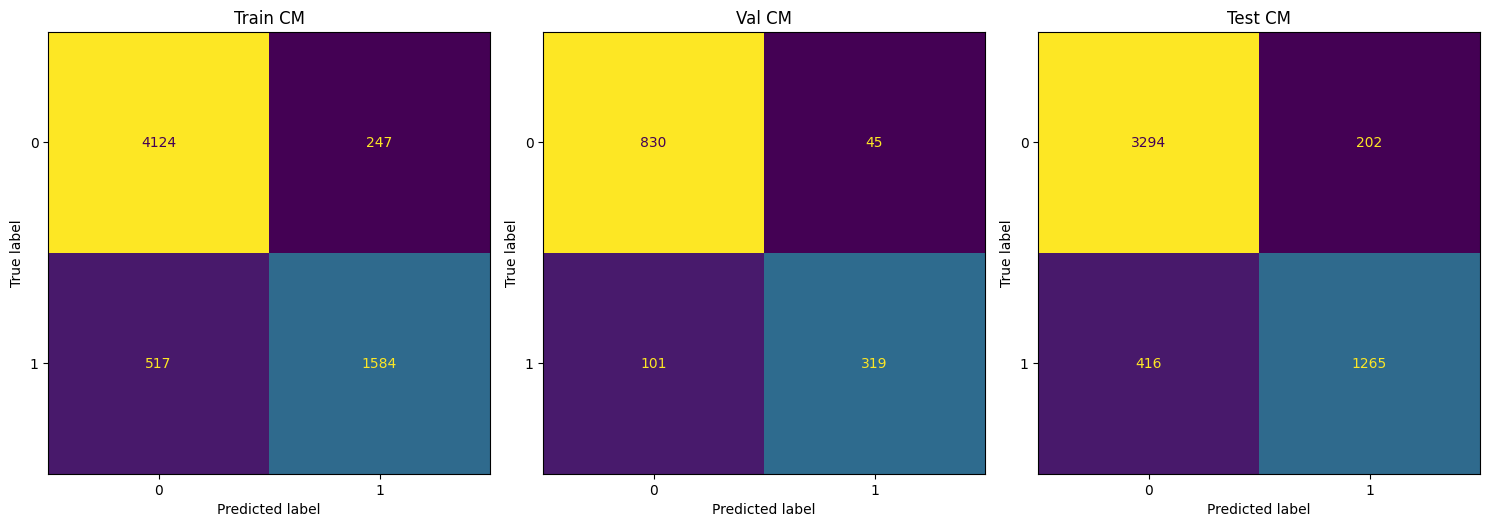

In [74]:
# Crear figuras y ejes
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 fila, 3 columnas

# Matriz de confusión para el conjunto de entrenamiento
cm_dtr_train = confusion_matrix(y_train, y_predict_dtr_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_dtr_train)
disp.plot(ax=axes[0], colorbar=False)
axes[0].set_title('Train CM')

# Matriz de confusión para el conjunto de validación
cm_dtr_val = confusion_matrix(y_val, y_predict_dtr_val)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_dtr_val)
disp.plot(ax=axes[1], colorbar=False)
axes[1].set_title('Val CM')

# Matriz de confusión para el conjunto de prueba
cm_dtr_test = confusion_matrix(y_test, y_predict_dtr_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_dtr_test)
disp.plot(ax=axes[2], colorbar=False)
axes[2].set_title('Test CM')

# Ajustar el espacio entre los gráficos
plt.tight_layout()
plt.show()

## Linear Support Vector Classifier

In [76]:
# Definir el diccionario de hiperparámetros
# La salida arroja observaciones debido a que algunas combinaciones de los hiperparámetros no son válidas.
linear_svc_params = dict(
    C=[0.1, 1, 10, 100],              # Parámetro de regularización
    penalty=['l1', 'l2'],              # Tipo de penalización (solo 'l2' está soportado por defecto)
    loss=['hinge', 'squared_hinge'],   # Función de pérdida
    dual=[False, True],                # Estrategia de resolución dual o primal
    max_iter=[1000, 2000, 3000]        # Número máximo de iteraciones
)

# Configurar RandomizedSearchCV
n_iter_search = 15
svc_random_search = RandomizedSearchCV(
    svc_model, 
    param_distributions=linear_svc_params, 
    n_iter=n_iter_search, 
    n_jobs=-1, 
    verbose=3, 
    scoring=scoring, 
    refit='precision'
)

# Ajustar el modelo
svc_random_search.fit(X_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


c:\Users\drjla\OneDrive\Desktop\MNA\proyecto\Advanced_drug_discovery\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
40 fits failed out of a total of 75.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\drjla\OneDrive\Desktop\MNA\proyecto\Advanced_drug_discovery\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\drjla\OneDrive\Desktop\MNA\proyecto\Advanced_drug_discovery\.venv\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^

RandomizedSearchCV(estimator=LinearSVC(dual=False, random_state=4), n_iter=15,
                   n_jobs=-1,
                   param_distributions={'C': [0.1, 1, 10, 100],
                                        'dual': [False, True],
                                        'loss': ['hinge', 'squared_hinge'],
                                        'max_iter': [1000, 2000, 3000],
                                        'penalty': ['l1', 'l2']},
                   refit='precision',
                   scoring={'accuracy': make_scorer(accuracy_score, response_method='predict'),
                            'f1_score': make_scorer(f1_score, response_method='predict'),
                            'precision': make_scorer(precision_score, response_method='predict'),
                            'recall': make_scorer(recall_score, response_method='predict')},
                   verbose=3)

In [79]:
# Mejor estimador encontrado
svc_random_search.best_estimator_

LinearSVC(C=0.1, dual=False, random_state=4)

In [80]:
svc_random_search.scorer_

{'accuracy': make_scorer(accuracy_score, response_method='predict'),
 'precision': make_scorer(precision_score, response_method='predict'),
 'recall': make_scorer(recall_score, response_method='predict'),
 'f1_score': make_scorer(f1_score, response_method='predict')}

In [81]:
# Predice valores de y
y_predict_svc_train = svc_random_search.predict(X_train)
y_predict_svc_val = svc_random_search.predict(X_val)
y_predict_svc_test = svc_random_search.predict(X_test)

# Calcula la precisión:
accuracy_svc_train = accuracy_score(y_train,y_predict_svc_train)
accuracy_svc_val = accuracy_score(y_val,y_predict_svc_val)
accuracy_svc_test = accuracy_score(y_test,y_predict_svc_test)

print(f'Accuracy train {accuracy_svc_train}')
print(f'Accuracy val {accuracy_svc_val}')
print(f'Accuracy test {accuracy_svc_test}')


Accuracy train 0.7124536464771323
Accuracy val 0.7142857142857143
Accuracy test 0.7119953641104887


In [82]:
# Scores
print(classification_report(y_train, y_predict_svc_train, target_names=['positive','negative']))
print(classification_report(y_val, y_predict_svc_val, target_names=['positive','negative']))
print(classification_report(y_test, y_predict_svc_test, target_names=['positive','negative']))

              precision    recall  f1-score   support

    positive       0.73      0.91      0.81      4371
    negative       0.61      0.31      0.41      2101

    accuracy                           0.71      6472
   macro avg       0.67      0.61      0.61      6472
weighted avg       0.69      0.71      0.68      6472

              precision    recall  f1-score   support

    positive       0.73      0.90      0.81       875
    negative       0.61      0.32      0.42       420

    accuracy                           0.71      1295
   macro avg       0.67      0.61      0.62      1295
weighted avg       0.70      0.71      0.68      1295

              precision    recall  f1-score   support

    positive       0.73      0.91      0.81      3496
    negative       0.61      0.31      0.41      1681

    accuracy                           0.71      5177
   macro avg       0.67      0.61      0.61      5177
weighted avg       0.69      0.71      0.68      5177



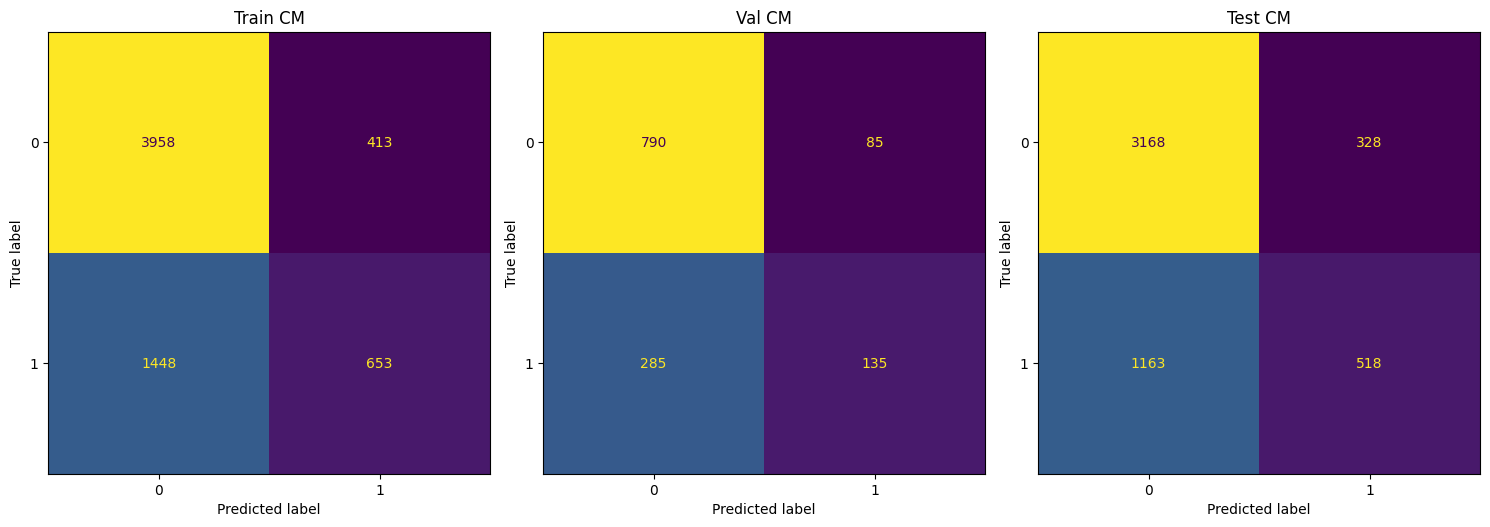

In [83]:
# Crear figuras y ejes
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 fila, 3 columnas

# Matriz de confusión para el conjunto de entrenamiento
cm_svc_train = confusion_matrix(y_train, y_predict_svc_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_svc_train)
disp.plot(ax=axes[0], colorbar=False)
axes[0].set_title('Train CM')

# Matriz de confusión para el conjunto de validación
cm_svc_val = confusion_matrix(y_val, y_predict_svc_val)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_svc_val)
disp.plot(ax=axes[1], colorbar=False)
axes[1].set_title('Val CM')

# Matriz de confusión para el conjunto de prueba
cm_svc_test = confusion_matrix(y_test, y_predict_svc_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_svc_test)
disp.plot(ax=axes[2], colorbar=False)
axes[2].set_title('Test CM')

# Ajustar el espacio entre los gráficos
plt.tight_layout()
plt.show()

## Pasive Agresive Classifier